# Análise de Churn de Funcionários

A empresa Komorebi quer reduzir os custos em contratação de substitos para os funcionários que deixaram a instituição. Para isso,o RH está precisando entender quais os fatores determinantes para o pedido de demissão.

## Objetivo
Construir um modelo que possa prever se o funcionário vai ou não deixar a empresa e quais fatores são considerados para a decisão de demissão.

A base de dados "HR_Abandono.csv" contém um conjunto de características sobre colaboradores de uma empresa, tais como:  

Coluna | Descrição
:-------|:------
satisfaction_level | nível de satisfação do colaborador com a empresa
last_evaluation | nota da última avaliação
average_montly_hours |  média de horas mensais trabalhadas
time_spend_company | tempo de empresa em anos
Work_accident | acidente de trabalho (1=Sim, 0=Não)
left | deixou a empresa (1=Sim, 0=Não)
promotion_last_5years | recebeu promoção nos últimos 5 anos (1=Sim, 0=Não)
salary | salário é classificado em baixo, médio ou alto
num_project | número de projetos
depto | departamento

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_recall_fscore_support, 
    roc_curve, 
    auc
    )

In [2]:
# Carregando os dados
df = pd.read_csv('HR_Abandono.csv', sep=';')
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
0,1,"0,38","0,53",157,3,0,1,0,low,2,sales
1,2,"0,8","0,86",262,6,0,1,0,medium,5,sales
2,3,"0,11","0,88",272,4,0,1,0,medium,6,sales
3,4,"0,72","0,87",223,5,0,1,0,low,5,sales
4,5,"0,37","0,52",159,3,0,1,0,low,2,sales


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   id                     14999 non-null  int64
 1   satisfaction_level     14999 non-null  str  
 2   last_evaluation        14999 non-null  str  
 3   average_montly_hours   14999 non-null  int64
 4   time_spend_company     14999 non-null  int64
 5   Work_accident          14999 non-null  int64
 6   left                   14999 non-null  int64
 7   promotion_last_5years  14999 non-null  int64
 8   salary                 14999 non-null  str  
 9   num_project            14999 non-null  int64
 10  depto                  14999 non-null  str  
dtypes: int64(7), str(4)
memory usage: 1.3 MB


In [4]:
# Trocando a vírgula por ponto em colunas numéricas
colunas = ['satisfaction_level', 'last_evaluation']
for coluna in colunas:
    df[coluna] = df[coluna].str.replace(',', '.').astype(float)

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14999 non-null  int64  
 1   satisfaction_level     14999 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  str    
 9   num_project            14999 non-null  int64  
 10  depto                  14999 non-null  str    
dtypes: float64(2), int64(7), str(2)
memory usage: 1.3 MB


In [5]:
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto
0,1,0.38,0.53,157,3,0,1,0,low,2,sales
1,2,0.80,0.86,262,6,0,1,0,medium,5,sales
2,3,0.11,0.88,272,4,0,1,0,medium,6,sales
3,4,0.72,0.87,223,5,0,1,0,low,5,sales
4,5,0.37,0.52,159,3,0,1,0,low,2,sales


In [6]:
# Verificando se há valores nulos
print("Valores nulos por coluna:")
display(df.isnull().sum())

# Verificando linhas duplicadas
print(f"\nNúmero de linhas duplicadas: {df.duplicated().sum()}")

Valores nulos por coluna:


id                       0
satisfaction_level       0
last_evaluation          0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
salary                   0
num_project              0
depto                    0
dtype: int64


Número de linhas duplicadas: 0


Os dados de abandono não possuem valores ausentes e nem linhas duplicadas.

In [7]:
df.describe()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,num_project
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7500.000000,0.612823,0.716102,201.083672,3.407027,0.144610,0.238083,0.021268,3.785986
std,4329.982679,0.248655,0.171169,50.182121,1.176120,0.351719,0.425924,0.144281,1.194539
min,1.000000,0.010000,0.360000,96.000000,2.000000,0.000000,0.000000,0.000000,2.000000
25%,3750.500000,0.440000,0.560000,156.000000,3.000000,0.000000,0.000000,0.000000,3.000000
50%,7500.000000,0.640000,0.720000,200.000000,3.000000,0.000000,0.000000,0.000000,4.000000
75%,11249.500000,0.820000,0.870000,245.000000,4.000000,0.000000,0.000000,0.000000,5.000000
max,14999.000000,1.000000,1.000000,810.000000,6.000000,1.000000,1.000000,1.000000,6.000000


* A média da satisfação dos funcionários é 0.61.
* Os funcionários trabalham em média 201 horas por mês.
* O tempo médio na empresa é de 3.4 anos.
* Número médio de projetos por funcionário é de 3.79.

In [8]:
salary = df['salary'].value_counts()
salary_percentual = round((salary / len(df) * 100),2)
salary_df = pd.DataFrame({'Quantidade': salary, 'Percentual (%)': salary_percentual})
salary_df

,Quantidade,Percentual (%)
salary,,
low,7316,48.78
medium,6446,42.98
high,1237,8.25


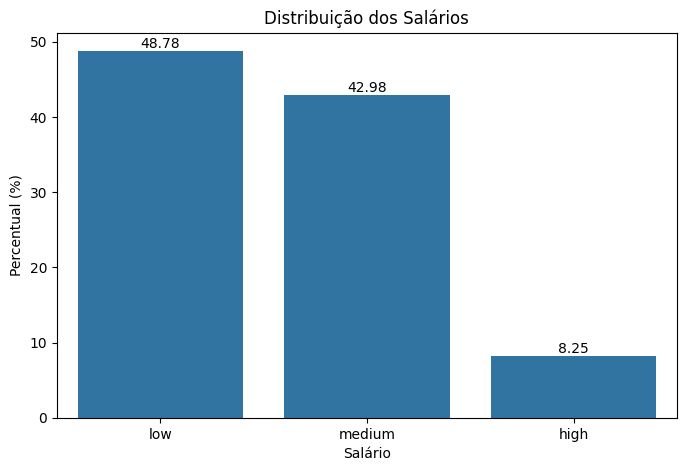

In [9]:
# Visualizando a distribuição dos salários
plt.figure(figsize=(8,5))
ax = sns.barplot(y='Percentual (%)', x=salary.index, data=salary_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribuição dos Salários')
plt.xlabel('Salário')
plt.ylabel('Percentual (%)')
plt.show()

* 48.78% dos funcionários recebem salários considerados baixos, enquanto 8.25% tem salários altos.

In [10]:
depto = df['depto'].value_counts()
depto_percentual = round((depto / len(df) * 100),2)
depto_df = pd.DataFrame({'Quantidade': depto, 'Percentual (%)': depto_percentual})
depto_df

,Quantidade,Percentual (%)
depto,,
sales,4140,27.60
technical,2720,18.13
support,2229,14.86
IT,1227,8.18
product_mng,902,6.01
marketing,858,5.72
RandD,787,5.25
accounting,767,5.11
hr,739,4.93


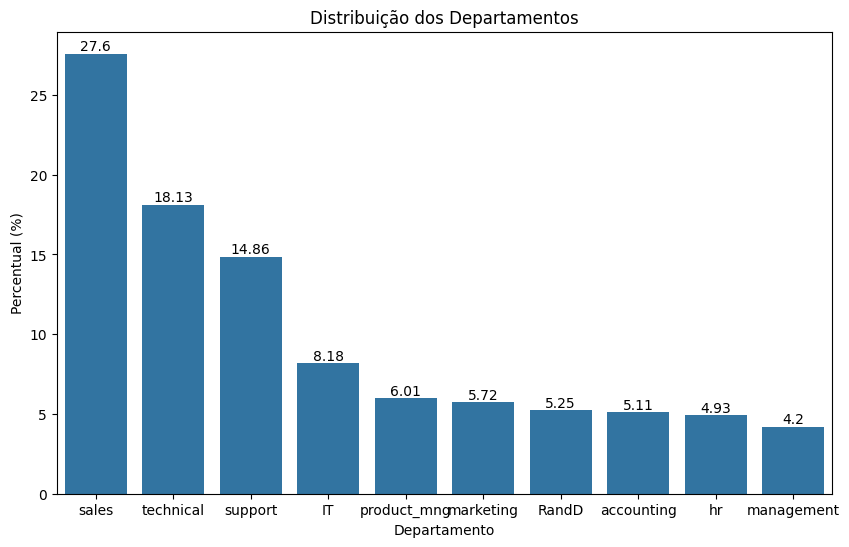

In [11]:
# Visualizando a distribuição dos departamentos
plt.figure(figsize=(10,6))
ax = sns.barplot(y='Percentual (%)', x=depto_df.index, data=depto_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribuição dos Departamentos')
plt.xlabel('Departamento')
plt.ylabel('Percentual (%)')
plt.show()

O departamento com maior número de funcionários é vendas (27.60%), seguido da área técnica (18.13%). Já o departamento com menor número de funcionário é o gerecial, com 630 gerentes.  

# Feature Engineering

In [12]:
df['avg_monthly_hours'] = df['average_montly_hours'] / df['time_spend_company']
df['satisfaction_evaluation_ratio'] = df['satisfaction_level'] / df['last_evaluation']
df['hours_per_project'] = df['average_montly_hours'] / df['num_project']
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,num_project,depto,avg_monthly_hours,satisfaction_evaluation_ratio,hours_per_project
0,1,0.38,0.53,157,3,0,1,0,low,2,sales,52.333333,0.716981,78.500000
1,2,0.80,0.86,262,6,0,1,0,medium,5,sales,43.666667,0.930233,52.400000
2,3,0.11,0.88,272,4,0,1,0,medium,6,sales,68.000000,0.125000,45.333333
3,4,0.72,0.87,223,5,0,1,0,low,5,sales,44.600000,0.827586,44.600000
4,5,0.37,0.52,159,3,0,1,0,low,2,sales,53.000000,0.711538,79.500000


# Análise Exploratória dos Dados

### Nível de Satisfação

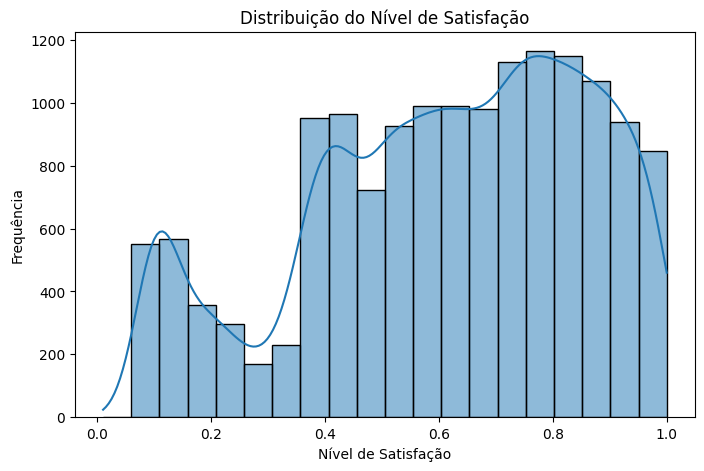

In [13]:
# Distribuição do nível de satisfação
plt.figure(figsize=(8,5))
sns.histplot(df['satisfaction_level'], bins=20, kde=True)
plt.title('Distribuição do Nível de Satisfação')
plt.xlabel('Nível de Satisfação')
plt.ylabel('Frequência')
plt.show()

### Última Avaliação

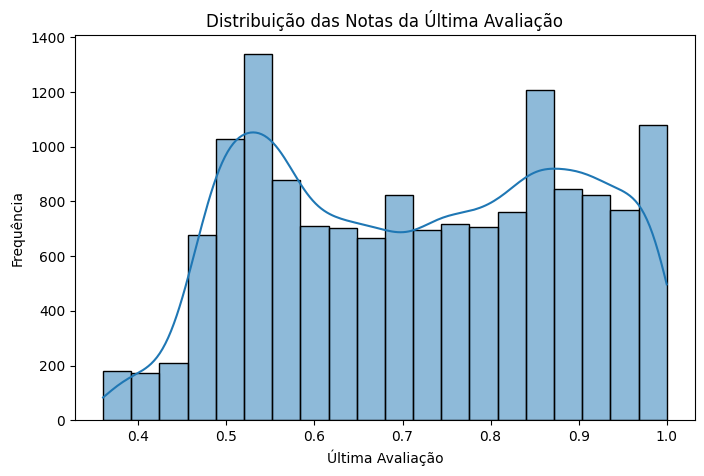

In [14]:
# Distribuição das notas da última avaliação
plt.figure(figsize=(8,5))
sns.histplot(df['last_evaluation'], bins=20, kde=True)
plt.title('Distribuição das Notas da Última Avaliação')
plt.xlabel('Última Avaliação')
plt.ylabel('Frequência')
plt.show()

### Média de Horas Trabalhadas por Mês

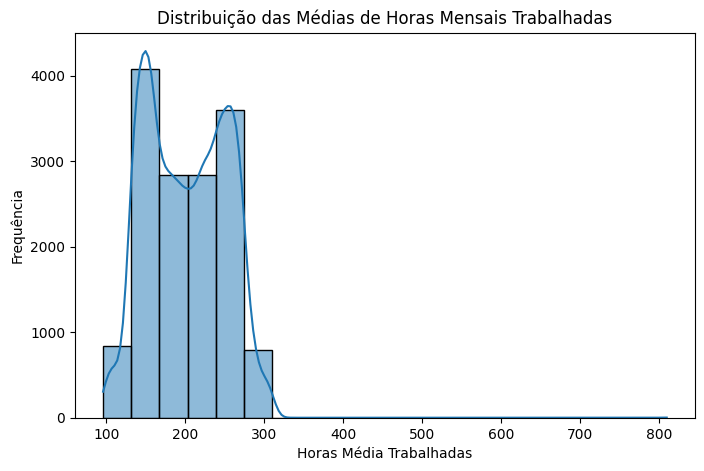

In [15]:
# Distribuição das Horas Trabalhadas
plt.figure(figsize=(8,5))
sns.histplot(df['average_montly_hours'], bins=20, kde=True)
plt.title('Distribuição das Médias de Horas Mensais Trabalhadas')
plt.xlabel('Horas Média Trabalhadas')
plt.ylabel('Frequência')
plt.show()

### Tempo de Empresa

In [16]:
tempo_empresa = df['time_spend_company'].value_counts().sort_index()
tempo_empresa_percentual = round((tempo_empresa / len(df) * 100),2)
tempo_empresa_df = pd.DataFrame({'Quantidade': tempo_empresa, 'Percentual (%)': tempo_empresa_percentual})

tempo_empresa_df.index.name = 'Anos na Empresa'
tempo_empresa_df.reset_index(inplace=True)
tempo_empresa_df

,Anos na Empresa,Quantidade,Percentual (%)
0,2,3244,21.63
1,3,6443,42.96
2,4,2557,17.05
3,5,1473,9.82
4,6,1282,8.55


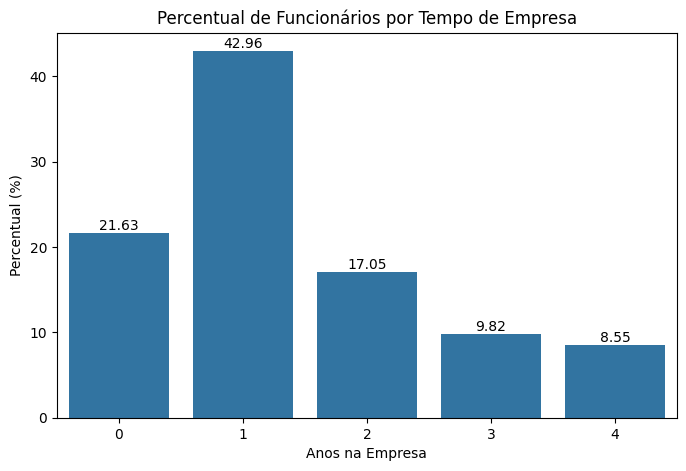

In [17]:
# Distribuição do tempo na empresa
plt.figure(figsize=(8,5))
ax = sns.barplot(y='Percentual (%)', x=tempo_empresa_df.index, data=tempo_empresa_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Percentual de Funcionários por Tempo de Empresa')
plt.xlabel('Anos na Empresa')
plt.ylabel('Percentual (%)')
plt.show()

### Acidente de Trabalho

In [57]:
acidente = df['Work_accident'].value_counts()
acidente_percentual = round((acidente / len(df) * 100),2)
acidente_df = pd.DataFrame({'Quantidade': acidente, 'Percentual (%)': acidente_percentual})

acidente_df.index = acidente_df.index.map({0: 'Não', 1: 'Sim'})
acidente_df.index.name = 'Acidente de Trabalho'
acidente_df.reset_index(inplace=True)
acidente_df

,Acidente de Trabalho,Quantidade,Percentual (%)
0,Não,12830,85.54
1,Sim,2169,14.46


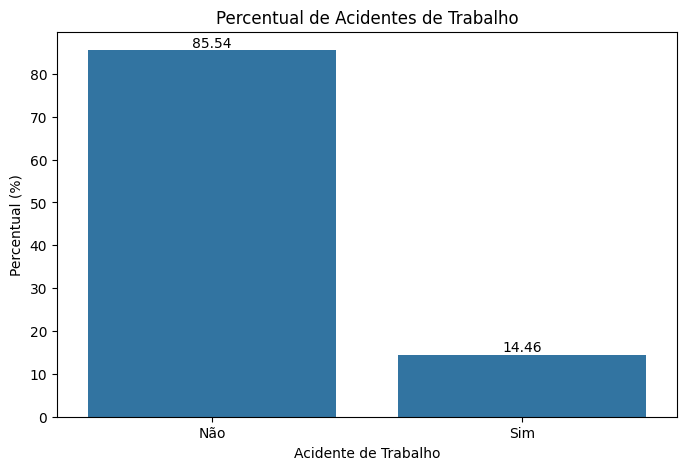

In [19]:
# Distribuição da Quantidade de acidentes de trabalho
plt.figure(figsize=(8,5))
ax = sns.barplot(x=acidente_df.index, y='Percentual (%)', data=acidente_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Percentual de Acidentes de Trabalho')
plt.xlabel('Acidente de Trabalho')
plt.ylabel('Percentual (%)')
plt.show()

### Promoção

In [ ]:
# Proporção de funcionarios que abandoram a empresa
promocao = df['promotion_last_5years'].value_counts()
promocao_percentual = round((promocao / len(df) * 100),2)
promocao_df = pd.DataFrame({'Quantidade': promocao, 'Percentual (%)': promocao_percentual})
promocao_df

# Renomeando os valores da coluna 'left'
promocao_df.index = promocao_df.index.map({0: 'Não', 1: 'Sim'})
promocao_df.index.name = 'Promoção nos Últimos 5 Anos'
promocao_df.reset_index(inplace=True)
promocao_df

,Quantidade,Percentual (%)
Promoção nos Últimos 5 Anos,,
Não,14680,97.87
Sim,319,2.13


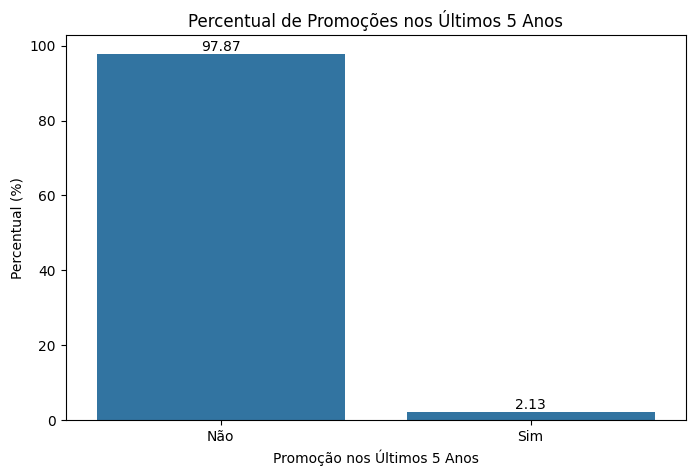

In [21]:
# Distribuição dos funcionários que receberam promoção no último 5 anos
plt.figure(figsize=(8,5))
ax = sns.barplot(x=promocao_df.index, y='Percentual (%)', data=promocao_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Percentual de Promoções nos Últimos 5 Anos')
plt.xlabel('Promoção nos Últimos 5 Anos')
plt.ylabel('Percentual (%)')
plt.show()

### Número de projetos

In [ ]:
projetos = df['num_project'].value_counts()
projetos_percentual = round((projetos / len(df) * 100),2)
projetos_df = pd.DataFrame({'Quantidade': projetos, 'Percentual (%)': projetos_percentual})
projetos_df.index.name = 'Número de Projetos'
projetos_df.reset_index(inplace=True)
projetos_df

,Quantidade,Percentual (%)
Número de Projetos,,
4,4365,29.10
3,4055,27.04
5,2761,18.41
2,2388,15.92
6,1430,9.53


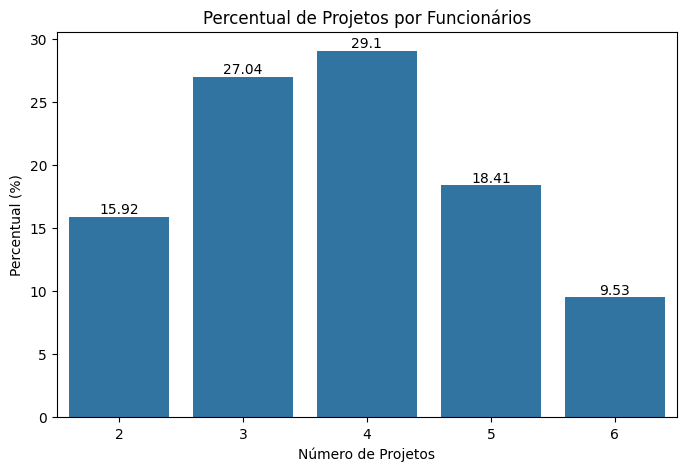

In [23]:
# Distribuição dos números de projetos
plt.figure(figsize=(8,5))
ax = sns.barplot(y='Percentual (%)', x=projetos_df.index, data=projetos_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Percentual de Projetos por Funcionários')
plt.xlabel('Número de Projetos')
plt.ylabel('Percentual (%)')
plt.show()

### Abandono

In [ ]:
# Proporção de funcionários que abandoram a empresa
abandono = df['left'].value_counts()
abandono_percentual = round((abandono / len(df) * 100),2)
abandono_df = pd.DataFrame({'Quantidade': abandono, 'Percentual (%)': abandono_percentual})
abandono_df.index = abandono_df.index.map({0: 'Não', 1: 'Sim'})
abandono_df.index.name = 'Abandono'
abandono_df.reset_index(inplace=True)
abandono_df

,Quantidade,Percentual (%)
Abandono,,
Não,11428,76.19
Sim,3571,23.81


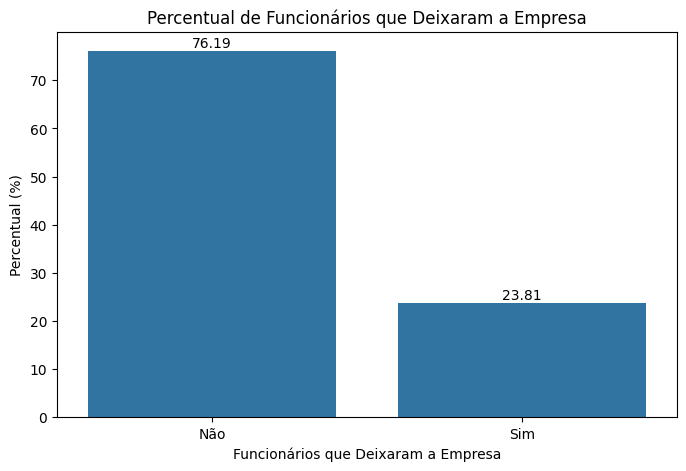

In [25]:
# Distribuição dos funcionários que deixaram a empresa
plt.figure(figsize=(8,5))
ax = sns.barplot(y='Percentual (%)', x=abandono_df.index, data=abandono_df)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Percentual de Funcionários que Deixaram a Empresa')
plt.xlabel('Funcionários que Deixaram a Empresa')
plt.ylabel('Percentual (%)')
plt.show()

# Teste de Hipótese

In [26]:
dados = df.copy()
dados['left'] = dados['left'].map({0: 'Permaneceu', 1: 'Saiu'})

### O nível de satisfação interfere na decisão de deixar a empresa?
* H0: o nível de satisfação é igual para quem saiu e quem permanceu
* H1: rejeita H0

Para isso vamos utilizar o teste t.


In [27]:
satisfacao_ficou = df[df['left'] == 0]['satisfaction_level']
satisfacao_saiu = df[df['left'] == 1]['satisfaction_level']

t_stat_satisfacao, p_value_satisfacao = stats.ttest_ind(satisfacao_ficou,
                                                        satisfacao_saiu,
                                                        equal_var=False)

print(f'Estatistica t: {t_stat_satisfacao}, p-valor: {p_value_satisfacao}')

Estatistica t: 46.635970904157084, p-valor: 0.0


Com o resultado do p-valor, rejeitamos H0. Desta forma, o nível de satisfação interfere na decisão de deixar a empresa.

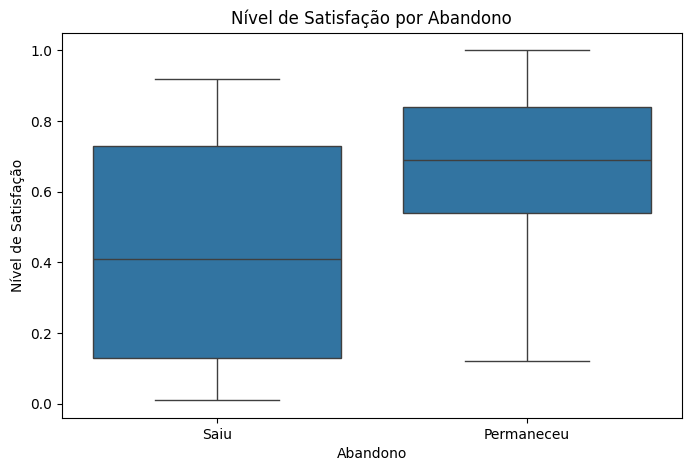

In [28]:
# Boxplot o nível de satisfação
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='satisfaction_level', data=dados)
plt.title('Nível de Satisfação por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Nível de Satisfação')
plt.show()

### A nota da última avaliação influencia no abandono?
* H0: não há diferença entre as avaliações para influenciar no abandono
* H1: rejeita H0

Vamos utilizar o test t

In [29]:
avaliacao_ficou = df[df['left'] == 0]['last_evaluation']
avaliacao_saiu = df[df['left'] == 1]['last_evaluation']

t_stat_avaliacao, p_value_avaliacao = stats.ttest_ind(avaliacao_ficou,
                                                      avaliacao_saiu,
                                                      equal_var=False)

print(f'Estatistica t: {t_stat_avaliacao}, p-valor: {p_value_avaliacao}')

Estatistica t: -0.7253423415891874, p-valor: 0.4682749613231913


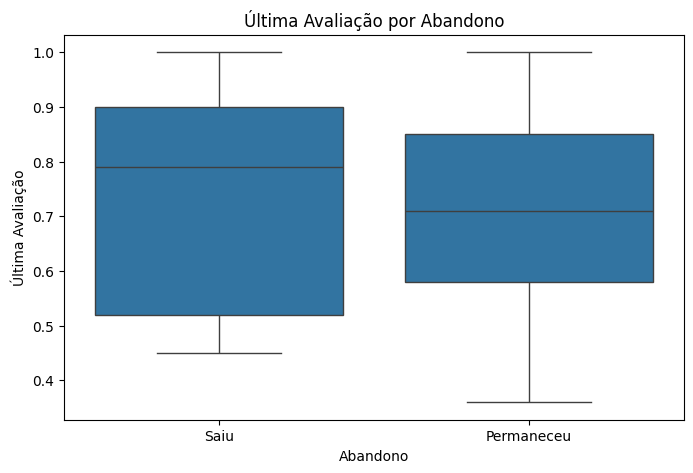

In [30]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='last_evaluation', data=dados)
plt.title('Última Avaliação por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Última Avaliação')
plt.show()

### A Quantidade de horas trabalhadas influencia no abandono?
* H0: a quantidade de horas não interfere na decisão de deixar a empresa
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [31]:
hora_ficou = df[df['left'] == 0]['average_montly_hours']
hora_saiu = df[df['left'] == 1]['average_montly_hours']

t_stat_hora, p_value_hora = stats.ttest_ind(hora_ficou,
                                            hora_saiu,
                                            equal_var=False)

print(f'Estatistica t: {t_stat_hora}, p-valor: {p_value_hora}')

Estatistica t: -7.573904010092895, p-valor: 4.312094345847752e-14


p-valor menor que 0.05, portanto rejeitamos H0. As horas trabalhadas interfere na decisão de deixar a empresa.

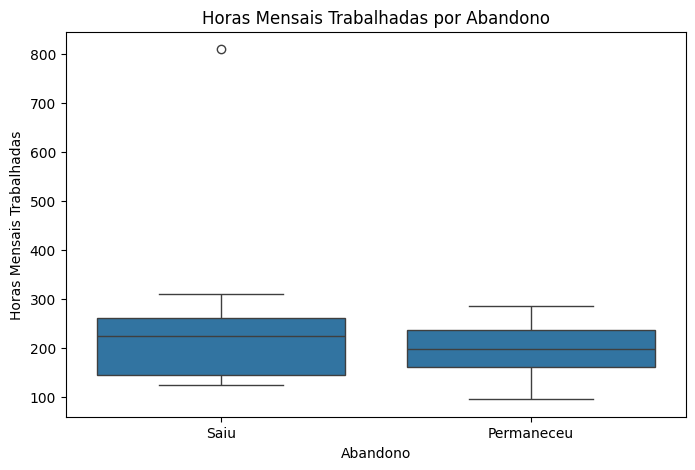

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='average_montly_hours', data=dados)
plt.title('Horas Mensais Trabalhadas por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Horas Mensais Trabalhadas')
plt.show()

### O tempo na empresa influencia no abandono?
* H0: o tempo na empresa não interfere na decisão de abandono
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [33]:
spend_ficou = df[df['left'] == 0]['time_spend_company']
spend_saiu = df[df['left'] == 1]['time_spend_company']

t_stat_spend, p_value_spend = stats.ttest_ind(spend_ficou,
                                              spend_saiu,
                                              equal_var=False)

print(f'Estatistica t: {t_stat_spend}, p-valor: {p_value_spend}')

Estatistica t: -31.1016833357108, p-valor: 2.335440878316137e-199


O p-valor é menor que 0.05, dessa forma rejeitamos H0. O tempo na empresa interfere na decisão de abandono.

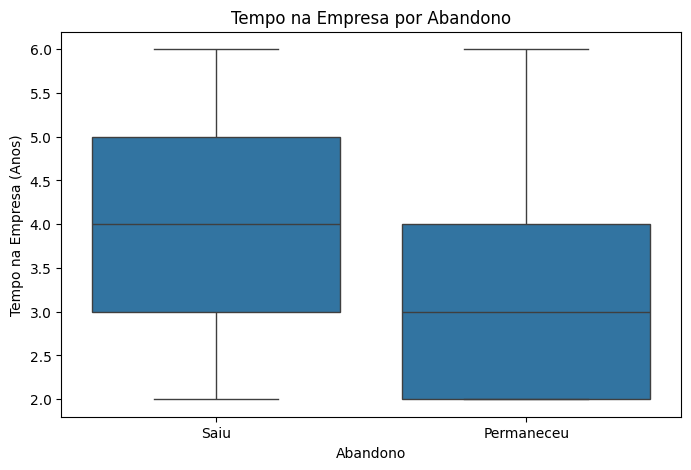

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x='left', y='time_spend_company', data=dados)
plt.title('Tempo na Empresa por Abandono')
plt.xlabel('Abandono')
plt.ylabel('Tempo na Empresa (Anos)')
plt.show()

### O numero de acidentes de trabalho influencia no abandono?

* H0: Não há relação entre o acidente de trabalho e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [35]:
# Teste Q-quadrado
acidente_abandono = pd.crosstab(df['Work_accident'], df['left'])
chi2_acidente, p_value_acidente, dof_acidente, expected_acidente = stats.chi2_contingency(acidente_abandono)
print(f'Q-quadrado: {chi2_acidente}. p-valor: {p_value_acidente} ')

Q-quadrado: 357.5623604097228. p-valor: 9.55823958002199e-80 


O p-valor deu menor que 0.05, portanto rejeita H0. Há relação entre o acidente de trabalho e o abandono.

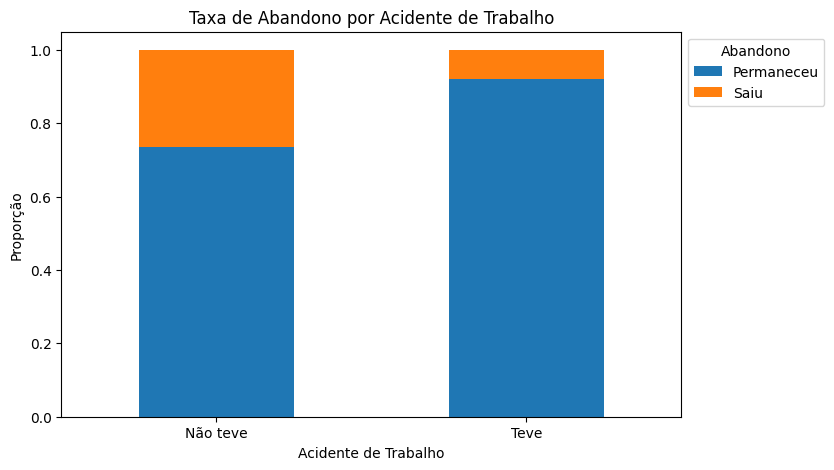

In [36]:
acidente_abandono = pd.crosstab(df['Work_accident'], df['left'], normalize='index')
acidente_abandono.index = acidente_abandono.index.map({0: 'Não teve', 1: 'Teve'})

plt.figure(figsize=(8,5))
acidente_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Acidente de Trabalho')
plt.xlabel('Acidente de Trabalho')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### Quem foi promovido nos ultimos 5 anos não abandonam a empresa?
* H0: Não há relação entre a promoção e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [37]:
# Teste Q-quadrado
promo_abandono = pd.crosstab(df['promotion_last_5years'], df['left'])
chi2_promo, p_value_promo, dof_promo, expected_promo = stats.chi2_contingency(promo_abandono)
print(f'Q-quadrado: {chi2_promo}. p-valor: {p_value_promo} ')

Q-quadrado: 56.26162726484021. p-valor: 6.344155457918697e-14 


Rejeitamos H0 com o p-valor. Portanto, há relação entre a promoção e o abandono dos funcionários.

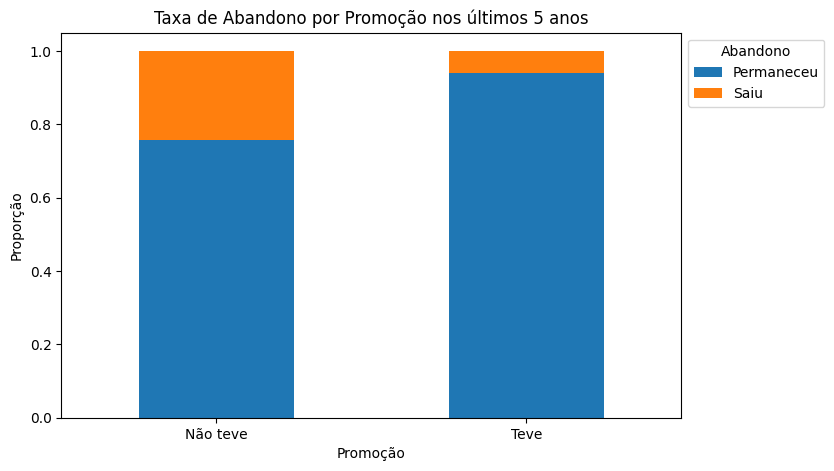

In [38]:
# Gráfico empilhado entre promoção e abandono
promo_abandono = pd.crosstab(df['promotion_last_5years'], df['left'], normalize='index')
promo_abandono.index = promo_abandono.index.map({0: 'Não teve', 1: 'Teve'})

plt.figure(figsize=(8,5))
promo_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Promoção nos últimos 5 anos')
plt.xlabel('Promoção')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### O salário influencia no abandono?
* H0: Não há relação entre o salário e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [39]:
# Teste Q-quadrado
salario_abandono = pd.crosstab(df['salary'], df['left'])
chi2_salario, p_value_salario, dof_salario, expected_salario = stats.chi2_contingency(salario_abandono)
print(f'Q-quadrado: {chi2_salario}. p-valor: {p_value_salario}')

Q-quadrado: 381.22504706621066. p-valor: 1.652086749295958e-83


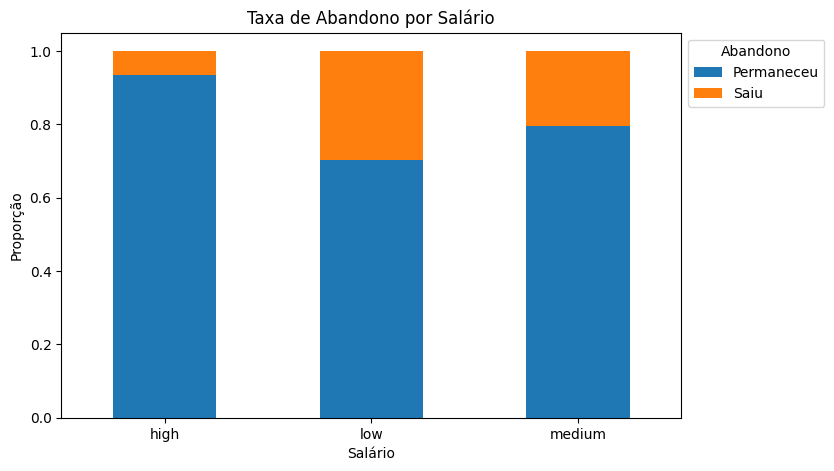

In [40]:
# Gráfico empilhado da taxa de abandono por salário
plt.figure(figsize=(8,5))
salario_abandono = pd.crosstab(df['salary'], df['left'], normalize='index')
salario_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Salário')
plt.xlabel('Salário')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


### Quem tem mais projetos abandonam a empresa?
* H0: o número de projeto não interfere na decisão de abandono
* H1: rejeita H0

Para esse teste vamos utilizar o teste t:

In [41]:
projeto_ficou = df[df['left'] == 0]['num_project']
projeto_saiu = df[df['left'] == 1]['num_project']

t_stat_projeto, p_value_projeto = stats.ttest_ind(projeto_ficou,
                                                  projeto_saiu,
                                                  equal_var=False)

print(f'Estatistica t: {t_stat_projeto}, p-valor: {p_value_projeto}')


Estatistica t: 0.09489924856746322, p-valor: 0.9243992478943522


O p-valor é maior que 0.05, então aceitamos H0. A variável em análise não interfere na decisão de deixar a empresa.

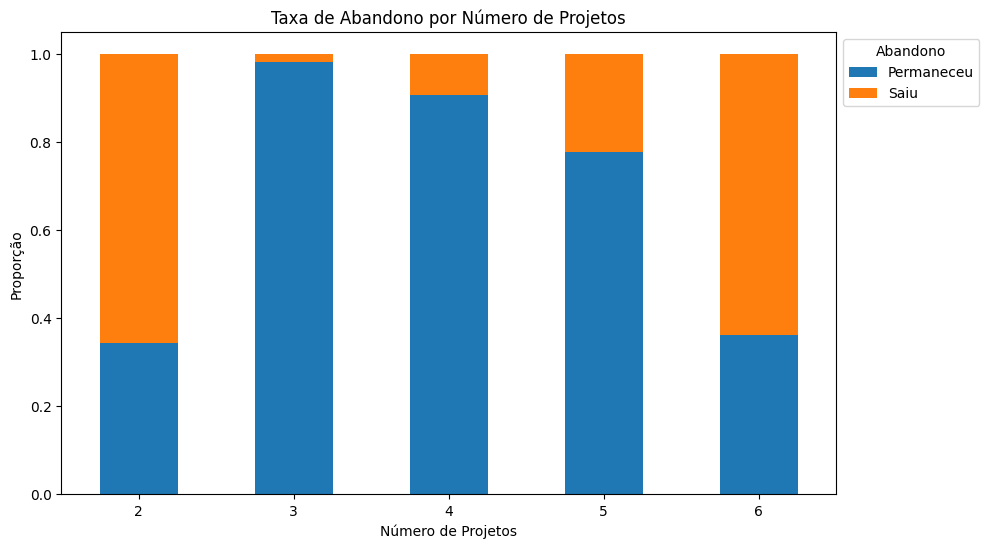

In [42]:
# Gráfico empilhado da taxa de abandono por projetos
plt.figure(figsize=(10,6))
projetos_abandono = pd.crosstab(df['num_project'], df['left'], normalize='index')
projetos_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Número de Projetos')
plt.xlabel('Número de Projetos')
plt.ylabel('Proporção')
plt.xticks(rotation=360)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'],  bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### O departamento interfere na decisão de deixar a empresa?

* H0: Não há relação entre o departamento e o abandono
* H1: rejeita H0

Para verificar a relação dessas duas variáveis vamos utilizar Q-quadrado.

In [43]:
# Teste Q-quadrado
depto_abandono = pd.crosstab(df['depto'], df['left'])
chi2_depto, p_value_depto, dof_depto, expected_depto = stats.chi2_contingency(depto_abandono)
print(f'Q-quadrado: {chi2_depto}. p-valor: {p_value_depto}')

Q-quadrado: 86.82547426790299. p-valor: 7.042130463822518e-15


P-valor é menor que 0.05. Rejeitamos H0.

Com isso, temos que o departamento interfere na decisão de deixar a empresa.

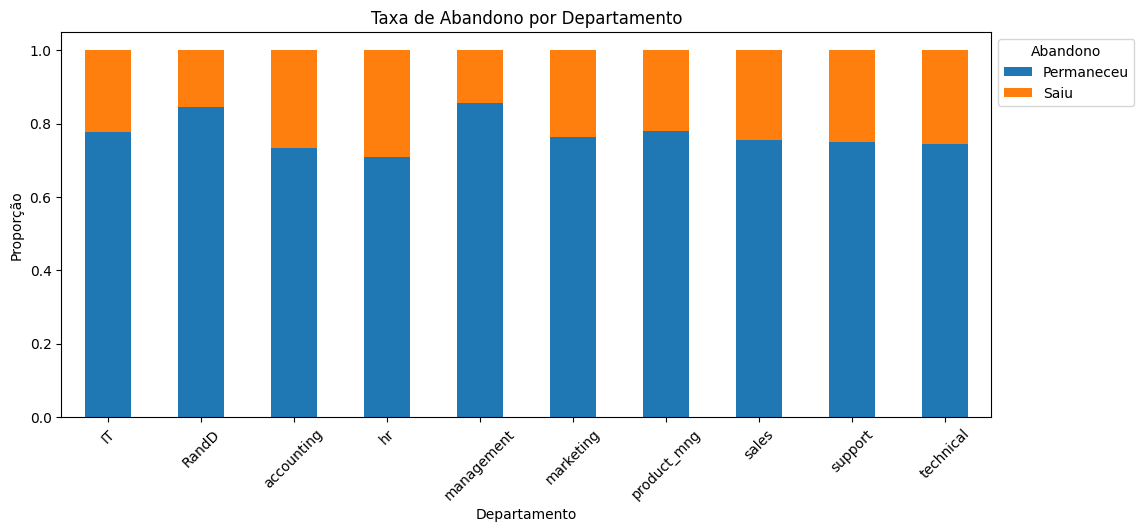

In [44]:
# Gráfico empilhado da taxa de abandono por departamento
plt.figure(figsize=(12,5))
dept_abandono = pd.crosstab(df['depto'], df['left'], normalize='index')
dept_abandono.plot(kind='bar', stacked=True, ax=plt.gca())  
plt.title('Taxa de Abandono por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Proporção')
plt.xticks(rotation=45)
plt.legend(title='Abandono', labels=['Permaneceu', 'Saiu'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Escalonamento

In [45]:
# Padronizando e Normalizando as variáveis categóricas
df = pd.get_dummies(df, columns=['salary', 'depto'], drop_first=True)

In [46]:
# Padronizando as variáveis numéricas
scaler = StandardScaler()
df[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']] = scaler.fit_transform(df[['satisfaction_level', 'last_evaluation', 'average_montly_hours', 'time_spend_company']])   
df.head()

,id,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,num_project,avg_monthly_hours,...,salary_medium,depto_RandD,depto_accounting,depto_hr,depto_management,depto_marketing,depto_product_mng,depto_sales,depto_support,depto_technical
0,1,-0.936361,-1.087275,-0.878503,-0.346088,0,1,0,2,52.333333,...,False,False,False,False,False,False,False,True,False,False
1,2,0.752784,0.840707,1.213945,2.204758,0,1,0,5,43.666667,...,True,False,False,False,False,False,False,True,False,False
2,3,-2.022240,0.957554,1.413226,0.504194,0,1,0,6,68.000000,...,True,False,False,False,False,False,False,True,False,False
3,4,0.431042,0.899131,0.436750,1.354476,0,1,0,5,44.600000,...,False,False,False,False,False,False,False,True,False,False
4,5,-0.976579,-1.145699,-0.838647,-0.346088,0,1,0,2,53.000000,...,False,False,False,False,False,False,False,True,False,False


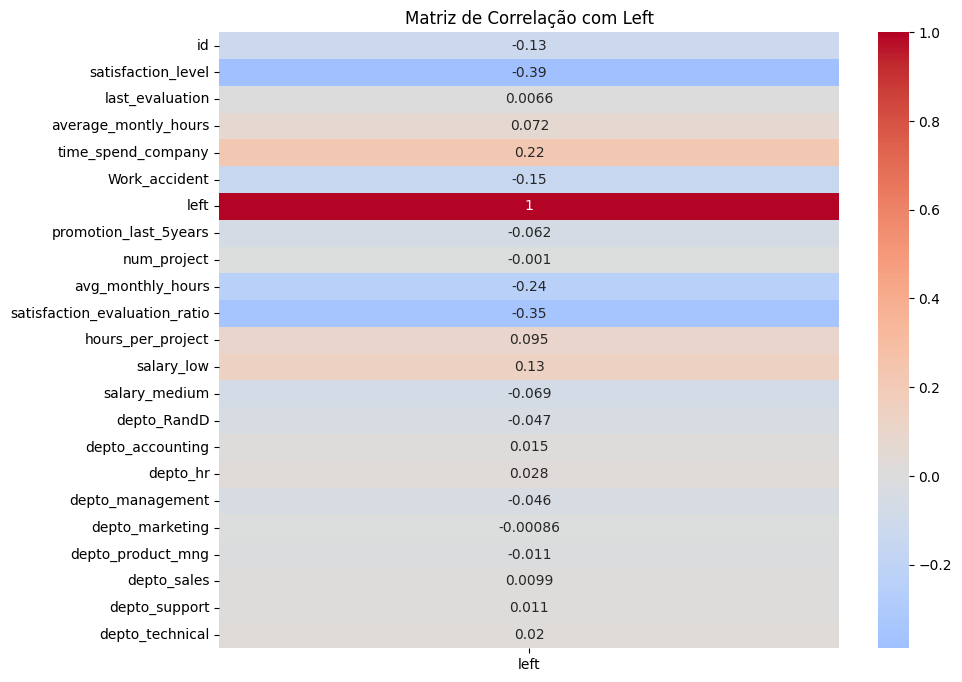

In [47]:
# Matriz de Correlação com Left
plt.figure(figsize=(10,8))
correlation_matrix = df.corr()['left'].to_frame ()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0) 
plt.title('Matriz de Correlação com Left')
plt.show()

In [48]:
# Features
X = df.drop('left', axis=1)

# Target
y = df['left']

In [49]:
# Dividindo o modelo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# Verificando as dimensões dos conjuntos de treino e teste
print(f'Tamanho do conjunto de treino: {X_train.shape}, {y_train.shape}')
print(f'Tamanho do conjunto de teste: {X_test.shape}, {y_test.shape}')

# Equilibrando as classes no conjunto de treino
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(f'\nDepois do SMOTE - Permanência (0): {sum(y_train == 0)}')
print(f'Depois do SMOTE - Abandono (1): {sum(y_train == 1)}')

Tamanho do conjunto de treino: (11999, 22), (11999,)
Tamanho do conjunto de teste: (3000, 22), (3000,)

Depois do SMOTE - Permanência (0): 9134
Depois do SMOTE - Abandono (1): 9134


# Modelos Utilizados

### Regressão Logística

In [51]:
modelo_logreg = LogisticRegression(random_state=42)
modelo_logreg.fit(X_train, y_train)

y_pred_rl = modelo_logreg.predict(X_test)

# Avaliando o modelo de Regressão Logística
acc = accuracy_score(y_test, y_pred_rl)
print(f'Acurácia do modelo Regressão Logística: {acc:.4f}\n')
print("Relatório de Classificação - Regressão Logística:")
print(classification_report(y_test, y_pred_rl))

Acurácia do modelo Regressão Logística: 0.8143

Relatório de Classificação - Regressão Logística:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2294
           1       0.57      0.82      0.67       706

    accuracy                           0.81      3000
   macro avg       0.75      0.81      0.77      3000
weighted avg       0.85      0.81      0.82      3000



c:\Users\User\Documents\GitHub\hr_abandono\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [52]:
model_rf = RandomForestClassifier(n_estimators=5, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

# Avaliando o modelo Random Forest
acc = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do modelo Random Forest: {acc:.4f}\n')
print("Relatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))

Acurácia do modelo Random Forest: 0.9943

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2294
           1       0.99      0.98      0.99       706

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



### SVM

In [53]:
model_svm = SVC(random_state=42)
model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

# Avaliando o modelo SVM
acc = accuracy_score(y_test, y_pred_svm)
print(f'Acurácia do modelo SVM: {acc:.4f}\n')
print("Relatório de Classificação - SVM:")
print(classification_report(y_test, y_pred_svm))

Acurácia do modelo SVM: 0.8773

Relatório de Classificação - SVM:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2294
           1       0.66      1.00      0.79       706

    accuracy                           0.88      3000
   macro avg       0.83      0.92      0.85      3000
weighted avg       0.92      0.88      0.88      3000



# Validação do Modelo

In [54]:
# Criando uma tabela comparativa de métricas para todos os modelos
modelos = {
    'Regressão Logística': (y_pred_rl, y_test),
    'Random Forest': (y_pred_rf, y_test),
    'SVM': (y_pred_svm, y_test)}

# Inicializar DataFrame vazio para armazenar as métricas
metrics_df = pd.DataFrame()

for nome_modelo, (y_pred, y_true) in modelos.items():
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)

    # Formatação das métricas
    def format_metrics(precision, recall, f1_score, accuracy):
        return round(precision, 4), round(recall, 4), round(f1_score, 4), round(accuracy, 4)
    
    p, r, f1, acc = format_metrics(precision, recall, f1_score, accuracy)
    
    # Adicionar dados ao DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Modelo': [nome_modelo],
        'Precision': [p],
        'Recall': [r],
        'F1 Score': [f1],
        'Acurácia': [acc]
    })], ignore_index=True)

metrics_df.set_index('Modelo', inplace=True)
display(metrics_df)

,Precision,Recall,F1 Score,Acurácia
Modelo,,,,
Regressão Logística,0.5743,0.8159,0.6741,0.8143
Random Forest,0.9914,0.9844,0.9879,0.9943
SVM,0.6574,1.0000,0.7933,0.8773


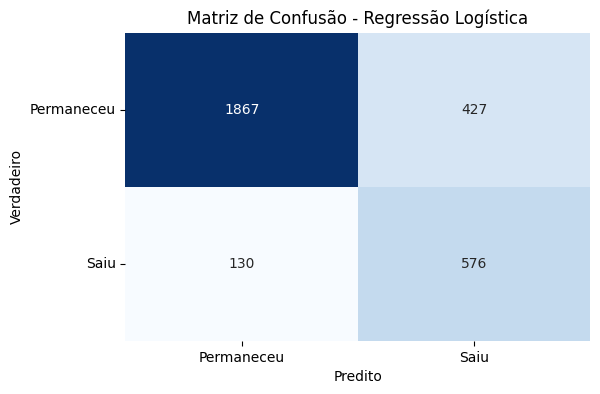

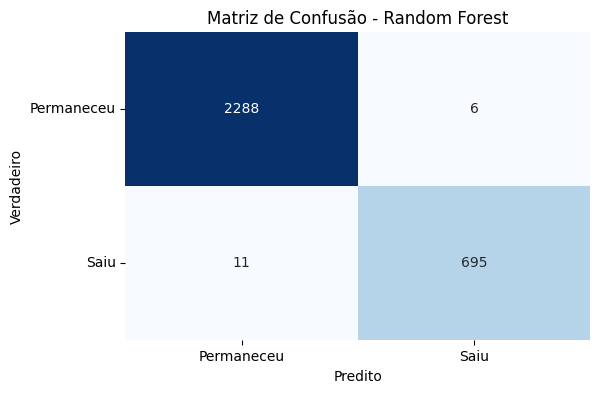

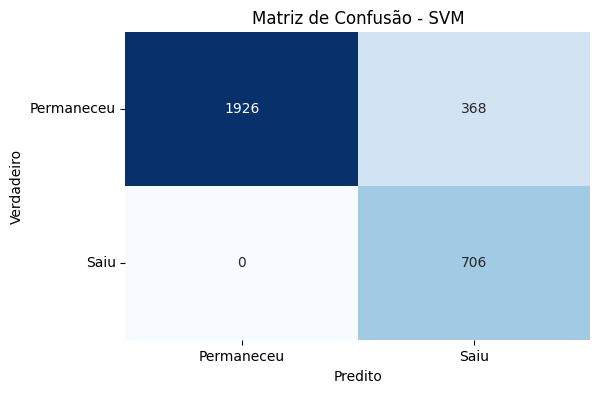

In [55]:
# Matriz de Confusão para cada modelo
for nome_modelo, (y_pred, y_true) in modelos.items():
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.xticks(ticks=[0.5, 1.5], labels=['Permaneceu', 'Saiu'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Permaneceu', 'Saiu'], rotation=0)
    plt.show()

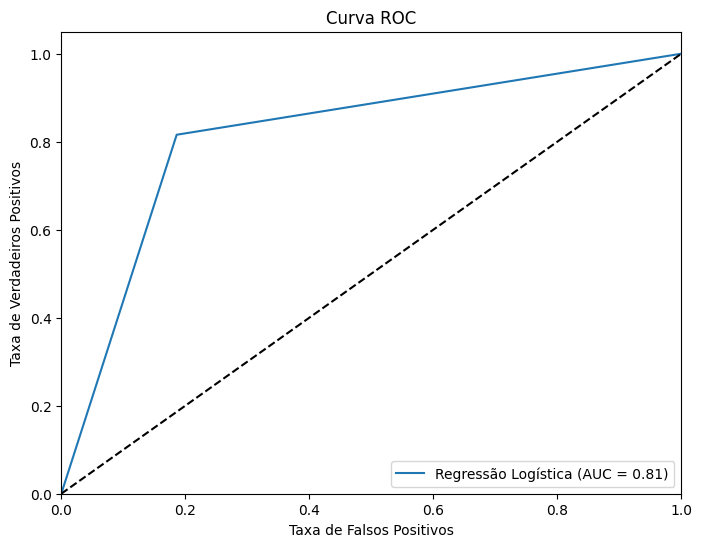

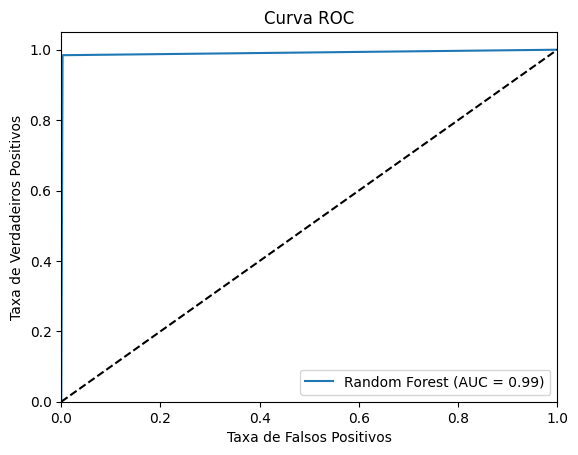

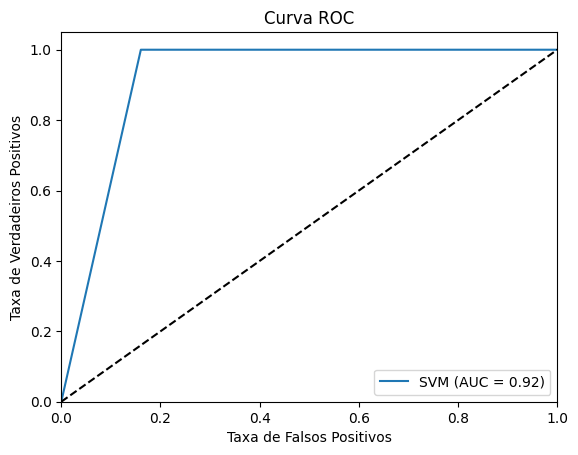

In [56]:
# ROC AUC para cada modelo
plt.figure(figsize=(8,6))
for nome_modelo, (y_pred, y_true) in modelos.items():
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nome_modelo} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Linha diagonal
    plt.xlim([0.0, 1.0])    
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

# Conclusão

Responder:

Melhor modelo

Principais variáveis

Tipo de erro mais crítico

---

Desafio do Módulo de Machine Learning Avançado - Fase 2. Pós Tech em Data Analytics (FIAP)